In [1]:
from kaggle_environments import evaluate, make, utils

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Classes and Methods to create and train DQN

In [3]:
class DQN(nn.Module):
    
    #need input space and output space
    def __init__(self, num_states, num_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=num_states, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_actions) # so num actions is gonna be wrong at some point cause you can't play in a certain position sometimes
        
    # t is input tensor
    def forward(self, t):
        # t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [4]:
# experience class
# create instances of experience objects that get stored in, and sampled from, the reply memory
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0 # keeps track of how many experiences we have added to memory
      
    # push method stores experiences in replay mem
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
            
        # if memory full, we overwrite the old memories
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    # returns a random sample of experiences
    # remember we need this to train the network
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # can we sample from memory yet? ie we only have 2 experiences but our batch size is 50
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        
        
        legal_moves = [c for c in range(self.num_actions) if state.board[c] == 0]
        
        # explore
        if rate > random.random():
            # action = random.randrange(self.num_actions)
            action = random.choice(legal_moves)
            return torch.tensor(action).to(self.device) # explore, before had as torch.tensor([action]).to(self.device)
        
        #exploit
        else:
            # doing the torch.no_grad() before we pass data to the policy net
            # to turn off gradient tracking b/c we using model for inference, not training
            
            state = torch.tensor(state.board).float().to(self.device)
            with torch.no_grad():
#                 return policy_net(state).argmax(dim=1).to(self.device) # exploit
                #action = policy_net(state).argmax().to() # exploit
    
    
                estimatedqvals = policy_net(state).to(self.device) # just using policy net output
        
                # gotta make sure this doesn't pick an already full column, so beef up the legal column q-vals
                for move in legal_moves:
                    estimatedqvals[move] += 10000


                return estimatedqvals.argmax().to(self.device)

In [8]:
class ConnectX():
    def __init__(self, trainer_choice):
#         self.device = device
        self.env = make('connectx', debug=True)
        self.trainer = self.env.train([None, trainer_choice])
        

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)
    
    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        return self.trainer.reset()

    def render(self):
        return self.env.render()
        #return self.env.render(**kwargs)
        
    # other methods
    def close(self):
        self.env.close()

    # should be like 7 or something, its the number of actions you can take
    def num_actions_available(self):
        return self.action_space.n # not just self.env.action_space.n cause env has none i guess
    
    def num_states(self):
        return self.observation_space.n

In [9]:
def plot(values, moving_avg_period):
    plt.figure(1)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('reward')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    
    if is_ipython:
        display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [10]:
# tensor processing
def extract_tensors(experiences):
    
    # Convert batch of Experiences to Experience of batches, see below
    batch = Experience(*zip(*experiences))

    t1 = torch.stack(batch.state)
    t2 = torch.stack(batch.action)
    t3 = torch.stack(batch.reward)
    t4 = torch.stack(batch.next_state)

    return (t1,t2,t3,t4)

In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [12]:
# Q value class - calculates the Q-vals

class QValues():
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        states = states.to(device)
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    
    
    '''
    remember for each next state, we want to obtain the maximum q value we could get for
    that next state (across all the possible actions).
    For a DQN, that max q value will be predicted by the target net
    
    The final states: when an episode ends (in our case its when the screen is all black, ie its all 0)
        We want to know where these final states are (if any) b/c we don't want to pass them to target net to
        get a predicted q-val. Q-val for final states is 0 b/c agent won't recieve a reward once episode has ended
    
    '''
    @staticmethod
    

    def get_next(target_net, next_states):
        next_states = next_states.to(device)
        return target_net(next_states).max(dim=1)[0]

In [13]:
def train_network(batch_size, gamma, eps_start, eps_end, eps_decay, target_update, memory_size, lr, num_episodes, train_against):

    # mydevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mydevice = torch.device("cpu")
    env = ConnectX(train_against)
    strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

    agent = Agent(strategy, env.num_actions_available(), mydevice)
    memory = ReplayMemory(memory_size)

    episode_durations = []
    episode_rewards = []

    policy_net = DQN(env.num_states(), env.num_actions_available()).to(mydevice)
    target_net = DQN(env.num_states(), env.num_actions_available()).to(mydevice)

    target_net.load_state_dict(policy_net.state_dict()) # setting the weights and biases to be the same as the policy net
    target_net.eval() # tells pytorch that network is not in training mode, only used for inference

    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

    # implementation of algorithim
    for episode in range(num_episodes):
        env.reset()
        state = env.reset()
        done = False
        r = 0

        for timestep in count():
            action = agent.select_action(state, policy_net) # is this expecting state as a tensor

            next_state, reward, done, info = env.step(action.item()) 

            # fix rewards
            if reward == 0:
                reward = -1
            elif reward == 0.5:
                reward = 0
            else:
                reward = 1
            r += reward
            
            memory.push(Experience(torch.tensor(state.board).float(), action, torch.tensor(next_state.board).float(), torch.tensor(reward, dtype=torch.float, device=mydevice))) # but why the [reward] and not just reward???
            state = next_state

            if memory.can_provide_sample(batch_size):
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)

                current_q_values = QValues.get_current(policy_net, states, actions) # returns q values for any state action pairs as predicted by the policy net, returned as a pytorch tensor

                # for each next state, we want to obtain the maximum q value (predicted by target net) among all possible next actions
                # This function will return the maximum q-values for the next states using using the best corresponding next actions
                next_q_values = QValues.get_next(target_net, next_states)
                target_q_values = (next_q_values * gamma) + rewards # calculating the target q-vals using the formula

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calc loss using mean squared error
                optimizer.zero_grad() # if we didn't zero out gradients, we would be accumulating gradients across all back prop runs.?????
                loss.backward() # computes gradient of loss wrt all weights and biases in the policy net
                optimizer.step() # updates the wrights and biases with the gradients that were computed when we called backward() 

            if done:
                episode_durations.append(timestep)
                episode_rewards.append(r)
#                     plot(episode_rewards, 100)
                break


        # check to see if we need to update the target network (remember we set it to multiples of 10)
        if episode % target_update == 0: 
            target_net.load_state_dict(policy_net.state_dict())
            
    return policy_net, episode_rewards

#### Agent creation

In [14]:
# function that creates function that plays game
def create_agent(policy_network):
    def my_agent(observation, configuration):

        # get set of legal moves
        legal_moves = [c for c in range(configuration.columns) if observation.board[c] == 0]

        # get the current layout of the board (why float tho, need to be floats for my dqn to work?)
        board = torch.tensor(observation.board).float()

        with torch.no_grad():
            estimatedqvals = policy_network(board)
            
            # gotta make sure this doesn't pick an already full column, so beef up the legal column q-vals
            for move in legal_moves:
                estimatedqvals[move] += 100
            return estimatedqvals.argmax().item()
        
    return my_agent  

In [15]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Agent 1 - train vs random opponent

In [16]:
# tune these hyperparameters to experiment with

batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 500

In [17]:

policy_net1, rewards = train_network(batch_size, gamma, eps_start, eps_end, eps_decay, target_update, memory_size, lr, num_episodes, "random")

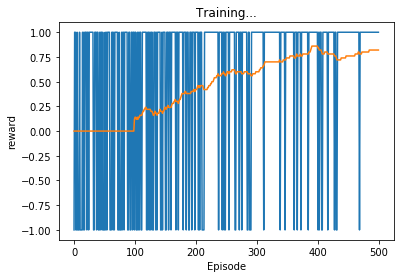

Episode 500 
 100 episode moving avg: 0.82


In [18]:
plot(rewards, 100)

## Evaluating the Agent

In [19]:
my_agent1 = create_agent(policy_net1)

In [20]:
# Run multiple episodes to estimate its performance.

print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent1, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent1, "negamax"], num_episodes=10)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent1], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent1], num_episodes=10)))

My Agent vs Random Agent: 1.0
My Agent vs Negamax Agent: 0.0
Random Agent vs. My Agent: 0.1
Negamax Agent vs. My Agent: 1.0


# Agent 2 - play against itself

In [39]:

policy_net2, rewards = train_network(batch_size, gamma, eps_start, eps_end, eps_decay, target_update, memory_size, lr, num_episodes, my_agent1)

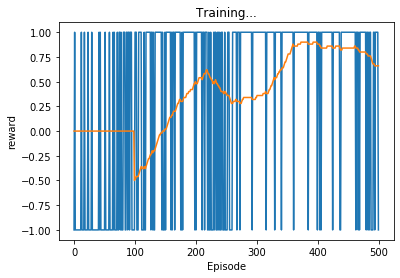

Episode 500 
 100 episode moving avg: 0.66


In [40]:
plot(rewards, 100)

In [41]:
my_agent2 = create_agent(policy_net2)

In [42]:
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent1, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent1, "negamax"], num_episodes=10)))

print("My Agent2 vs Random Agent:", mean_reward(evaluate("connectx", [my_agent2, "random"], num_episodes=10)))
print("My Agent2 vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent2, "negamax"], num_episodes=10)))

print("My Agent2 vs My Agent", mean_reward(evaluate("connectx", [my_agent2, my_agent1], num_episodes=10)))
print("My Agent2 vs My Agent", mean_reward(evaluate("connectx", [my_agent2, my_agent1], num_episodes=10)))

My Agent vs Random Agent: 0.9
My Agent vs Negamax Agent: 0.0
My Agent2 vs Random Agent: 0.7
My Agent2 vs Negamax Agent: 0.0
My Agent2 vs My Agent 1.0
My Agent2 vs My Agent 1.0


# Agent 3 - Train against itself many times

In [25]:
# train a network on previous network


n = 3
current_agent = my_agent2

for _ in range (n):
    current_net, _ =  train_network(batch_size, gamma, eps_start, eps_end, eps_decay, target_update, memory_size, lr, num_episodes, current_agent)
    current_agent = create_agent(current_net)
    
    
    
    
# create the agent out of the final net
agent3 = create_agent(current_net)

In [26]:


print("Agent 3 vs Agent 1", mean_reward(evaluate("connectx", [agent3, my_agent1], num_episodes=10)))
print("Agent 1 vs Agent 3", mean_reward(evaluate("connectx", [my_agent1, agent3], num_episodes=10)))
print()
print("Agent 3 vs Agent 2", mean_reward(evaluate("connectx", [agent3, my_agent2], num_episodes=10)))
print("Agent 2 vs Agent 3:", mean_reward(evaluate("connectx", [my_agent2, agent3], num_episodes=10)))






Agent 3 vs Agent 1 0.0
Agent 1 vs Agent 3 1.0

Agent 3 vs Agent 2 1.0
Agent 2 vs Agent 3: 0.0


# interactive

In [27]:
env = make("connectx", debug=True)

In [48]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent1, "random"])
env.render(mode="ipython", width=500, height=450)

In [46]:
env.reset()
# Play as the first agent against default "random" agent.
env.run(["random", my_agent1])
env.render(mode="ipython", width=500, height=450)

In [34]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent2, my_agent1])
env.render(mode="ipython", width=500, height=450)

In [30]:
policy_net2.fc1.weight

Parameter containing:
tensor([[ 0.0105,  0.1042,  0.0880,  ...,  0.2791,  0.0774,  0.1026],
        [ 0.1379, -0.0411,  0.0019,  ..., -0.1082, -0.1076, -0.4445],
        [ 0.1125, -0.0363,  0.0398,  ...,  0.0667, -0.3502, -0.3933],
        ...,
        [ 0.0801, -0.1549,  0.0548,  ...,  0.1899,  0.0120, -0.0522],
        [-0.1510,  0.0272,  0.1267,  ..., -0.1875, -0.0149,  0.1103],
        [ 0.0091,  0.0587,  0.1395,  ...,  0.0605, -0.1006, -0.2556]],
       requires_grad=True)

In [49]:
env.reset()
env.play([None, my_agent2], width=500, height=450)



negamax training 400 episodes: 6min 5s


- challenging to do rewards because it only recieves rewards after entire game

- all top 50 (at least) are not some form of min-max tree search, not NN

- A lot what I have been doing is trying to get code to run faster and preform better. Tweaking hyperparameters, running on gpu

- found that better than just teaking hyperamaters and newtork config (num layers, type of layers, configuration of the layers etc) I just keep training on past iterations 

try to do dualing neural network where it trains against itself, not just using the most recent thing